<a href="https://colab.research.google.com/github/Poredaka1020/Projects_Data_Science/blob/main/Pr%C3%A9paration_des_donn%C3%A9es_et_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction et objectifs

### Importation des différents modules

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install requests

In [2]:
import pandas as pd
# from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
from sklearn import linear_model

### Téléchargement des données

In [3]:
import requests
response = requests.get('https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/export?format=csv&gid=1150341366')
assert response.status_code == 200, 'Wrong status code'
# convert the csv to a pandas dataframe
with open('data.csv', 'w') as f:
    f.write(response.text)

df_house_price = pd.read_csv('data.csv')

Le but de ce notebook est d'effectuer le prétraitement du dataset [HousePricePrediction](https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/edit#gid=1150341366) qui pourra être par la suite utilisé pour entraîner un modèle de prédiction des prix de vente des maisons.

## Préparation des données

Plusieurs étapes sont nécessaires pour préparer un dataset pour la fouille des données
- **Nettoyage des données** :
    - Suppression des attributs inutiles
    - Gestion des valeurs manquantes
    - Gestion des valeurs aberrantes
- **Transformation des données** :
    - Encodage des données
    - Normalisation des données
- **Sélection des attributs** :
    - Suppression des attributs les plus fortement corrélés

## Sommaire

1. [Première observation des données](#1.-Première-observation-des-donnees)
2. [Nettoyage des données](#2.-Nettoyage-des-données)
   1. [Suppression des attributs inutiles](#2.1.-Suppression-des-attributs-inutiles)
   2. [Gestion des valeurs manquantes](#2.2.-Gestion-des-valeurs-manquantes)
   3. [Détection des valeurs aberrantes](#2.3.-Détection-des-valeurs-aberrantes)
3. [Transformation des données](#3.-Transformation-des-données)
   1. [Encodage des attributs de type `object`](#3.1.-Encodage-des-attributs-de-type-object)
   2. [Normalisation des données](#3.2.-Normalisation-des-données)
4. [Sélection des attributs](#4.-Sélection-des-variables)
   1. [Suppression des attributs corrélées](#4.1.-Suppression-des-variables-corrélées)
5. [Récapitulatif des procédés](#5.-Récapitulatif-des-prétraitements)
6. [Entrainement d'un modèle de régression linéaire](#6.-Récapitulatif-des-prétraitements)
    1. [Rappel du concept](#6.1.-Rappel-concept)
    2. [Application](#6.2.-Application)
7. [Bonus : méthode des écarts interquartiles ou IRQ](#7.-Récapitulatif-des-prétraitements)

## 1. Exploration des données

Nous vous avons fourni le fichier *data.csv* avec l'exécution de la deuxième cellule. Il contient l'ensemble des données. Chaque ligne contient les données d'une vente. La description des attributs du dataset est la suivante:

| # | Feature Name | Description |
|---|--------------|-------------|
| 1 | Id           | Numéro de vente / To count the records. |
| 2 | MSSubClass   | Type de logement / Identifies the type of dwelling involved in the sale. |
| 3 | MSZoning     | Zonage / Identifies the general zoning classification of the sale. |
| 4 | LotArea      | Superficie du logement / Lot size in square feet. |
| 5 | LotConfig    | Configuration du logement / Configuration of the lot |
| 6 | BldgType     | Type de logement / Type of dwelling |
| 7 | OverallCond  | Etat général / Rates the overall condition of the house |
| 8 | YearBuilt    | Année de construction / Original construction year |
| 9 | YearRemodAdd | Année de rénovation / Remodel date (same as construction date if no remodeling or additions). |
| 10| Exterior1st  | Type de revêtement extérieur / Exterior covering on house |
| 11| BsmtFinSF2   | Surface de vie / Type 2 finished square feet. |
| 12| TotalBsmtSF  | Surface totale de la base / Total square feet of basement area |
| 13| SalePrice    | Prix de vente à prédire / To be predicted |

On visualise le dataset pour avoir une idée de ce qu'il contient et des prétraitements à effectuer.

In [4]:
df_house_price

,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2914,160,RM,1936,Inside,Twnhs,7,1970,1970,CemntBd,0.0,546.0,NaN
2915,2915,160,RM,1894,Inside,TwnhsE,5,1970,1970,CemntBd,0.0,546.0,NaN
2916,2916,20,RL,20000,Inside,1Fam,7,1960,1996,VinylSd,0.0,1224.0,NaN
2917,2917,85,RL,10441,Inside,1Fam,5,1992,1992,HdBoard,0.0,912.0,NaN


### 1.1 - Question 1

**Combien d'éléments contient le dataset ? Quelles sont les types des attributs du dataset ?**

In [5]:
print("Le nombre d'éléments dans le dataset : ", len(df_house_price))
print("**********************")
print("Les types des attributs du dataset : ")
df_house_price.info(show_counts=False)

Le nombre d'éléments dans le dataset :  2919
**********************
Les types des attributs du dataset : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Id            int64  
 1   MSSubClass    int64  
 2   MSZoning      object 
 3   LotArea       int64  
 4   LotConfig     object 
 5   BldgType      object 
 6   OverallCond   int64  
 7   YearBuilt     int64  
 8   YearRemodAdd  int64  
 9   Exterior1st   object 
 10  BsmtFinSF2    float64
 11  TotalBsmtSF   float64
 12  SalePrice     float64
dtypes: float64(3), int64(6), object(4)
memory usage: 296.6+ KB


### 1.2 - Question 2

**Quelles sont les valeurs uniques des attributs de type `object` ?**

In [6]:
df_objects_columns = df_house_price.select_dtypes(exclude=['number'])
for col in df_objects_columns.columns:
  valeurs_uniques = df_objects_columns[col].unique()
  print(f"Les valeurs uniques dans la colonne {col} sont : {valeurs_uniques}")
  # print("Les valeurs uniques dans {} sont : {}".format(col, valeurs_uniques))

Les valeurs uniques dans la colonne MSZoning sont : ['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
Les valeurs uniques dans la colonne LotConfig sont : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Les valeurs uniques dans la colonne BldgType sont : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Les valeurs uniques dans la colonne Exterior1st sont : ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' nan]


## 2. Nettoyage des données

### 2.1 Suppression des attributs inutiles

### 2.1.1 - Question 3

**Pourquoi on peut supprimer l'attribut `Id` dans le cas de ce TP? Effectuez cette suppression.**

*Je peux supprimer l'attribut Id parce qu'il est le double de l'index (les mêmes valeurs).*

In [7]:
df_house_price = df_house_price.drop("Id", axis=1)

In [8]:
df_house_price

,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,1936,Inside,Twnhs,7,1970,1970,CemntBd,0.0,546.0,NaN
2915,160,RM,1894,Inside,TwnhsE,5,1970,1970,CemntBd,0.0,546.0,NaN
2916,20,RL,20000,Inside,1Fam,7,1960,1996,VinylSd,0.0,1224.0,NaN
2917,85,RL,10441,Inside,1Fam,5,1992,1992,HdBoard,0.0,912.0,NaN


### 2.2 Gestion des valeurs manquantes

Pour gérer les valeurs manquantes, plusieurs solutions s'offrent à nous :
- Remplacer par la valeur la plus fréquente (le mode)
- Remplacer par la valeur moyenne/médiane
- Suppression des lignes contenant des valeurs manquantes

Pour ce TP, nous utiliserons la dernière option car nous avons peu de valeurs manquantes.

#### 2.2.1 - Question 4

**Quels attributs contiennent des valeurs manquantes ?**

In [9]:
missing_values = df_house_price.isna().sum() > 0
missing_values.sort_values(ascending=False)

MSZoning         True
Exterior1st      True
BsmtFinSF2       True
TotalBsmtSF      True
SalePrice        True
MSSubClass      False
LotArea         False
LotConfig       False
BldgType        False
OverallCond     False
YearBuilt       False
YearRemodAdd    False
dtype: bool

*Les attributs qui contiennent des valeurs manquantes sont : MSZoning, Exterior1st, BsmtFinSF2, TotalBsmtSF et SalePrice.*

#### 2.2.2 - Question 5

On peut alors gérer les valeurs manquantes colonne par colonne. L'attribut `SalePrice` n'est pas pris en considération car les valeurs manquantes sont justement les valeurs que nous voulons prédire.

**Supprimer les lignes contenant les valeurs manquantes. Implémentez la fonction `delete_missing_values` qui retire ces données**.

In [10]:
def delete_missing_values(dataset):
    dataset_traite = dataset.dropna(subset=["MSZoning", "Exterior1st", "BsmtFinSF2", "TotalBsmtSF"])
    return dataset_traite

In [11]:
df_house_price = delete_missing_values(df_house_price)

In [12]:
df_house_price

,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,1936,Inside,Twnhs,7,1970,1970,CemntBd,0.0,546.0,NaN
2915,160,RM,1894,Inside,TwnhsE,5,1970,1970,CemntBd,0.0,546.0,NaN
2916,20,RL,20000,Inside,1Fam,7,1960,1996,VinylSd,0.0,1224.0,NaN
2917,85,RL,10441,Inside,1Fam,5,1992,1992,HdBoard,0.0,912.0,NaN


*Les données manquantes pour la colonne `SalePrice` sont celles du dataset de test. On laisse donc ces valeurs manquantes car on veut appliquer le même prétraitement sur les données de test.*

### 2.2.3 - Question 6

On veut néanmoins que les données d'entrainement suivent une distribution gaussienne.

**Implémenter le fonction `plot_hist`. Cette fonction doit permettre d'afficher la distribution des valeurs de l'attribut `SalePrice` ainsi que la loi normale de même moyenne et variance.**

In [13]:
def plot_hist(prices):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Distribution des valeurs du prix")
    sns.distplot(prices);

<ipython-input-13-fada84d09a25>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prices);


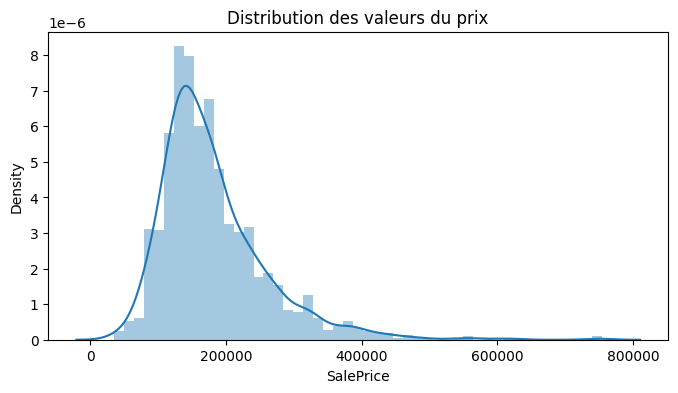

In [14]:
plot_hist(df_house_price['SalePrice'])

Vous devez obtenir une distribution des valeurs de `SalePrice` proches d'une distribution normale mais légèrement asymétrique. On peut alors appliquer une transformation logarithmique pour approcher d'une distribution normale symétrique.

**Effectuer cette transformation sur notre ensemble de données.**

In [15]:
df_house_price['SalePrice'] = np.log(df_house_price['SalePrice'])

<ipython-input-15-0f02dda78e72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_house_price['SalePrice'] = np.log(df_house_price['SalePrice'])


<ipython-input-13-fada84d09a25>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prices);


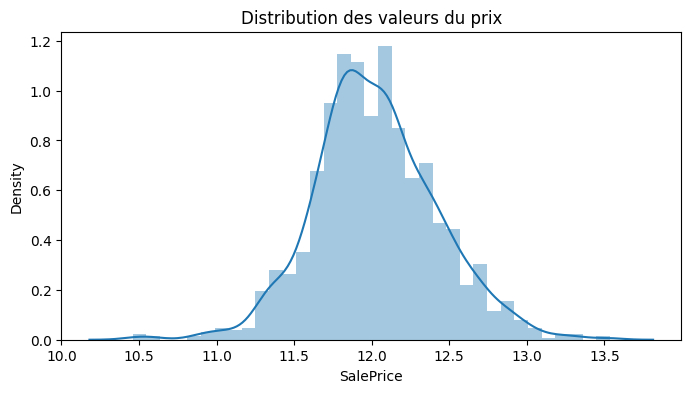

In [16]:
plot_hist(df_house_price['SalePrice'])

In [17]:
df_house_price['SalePrice']

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
2914          NaN
2915          NaN
2916          NaN
2917          NaN
2918          NaN
Name: SalePrice, Length: 2913, dtype: float64

In [18]:
# Pour révénir aux montants de départ du prix de ventes de chaque maison.
np.exp(df_house_price['SalePrice'])

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2913, dtype: float64

### 2.3 Détection des valeurs aberrantes

En pratique, la méthode de détection d'une valeur aberrante nécessite de se poser les questions suivantes:
- Quelles valeurs seraient incohérentes pour chaque colonne ?
- Quelles valeurs peuvent être problématiques pour l'utilisation de ces données ? Exemple: pour une régression linéaire, on préfère avoir des valeurs distribuées suivant une loi normale.

Avec ces éléments, on peut:
- Fixer des seuils de tolérance pour les valeurs aberrantes
- Utiliser des algorithmes de détection de valeurs aberrantes (ex: clustering, IRQ, [QTest](https://plotly.com/python/v3/outlier-test/), ...)

A noter que suivant les méthodes, les valeurs détectées comme aberrantes peuvent être différentes.

La méthode IRQ fait l'objet d'une partie bonus, en fin de ce notebook.

### 2.3.1 Question 7

Ici comme nous allons réaliser une régression linéaire, nous allons visuellement voir si certains points s'écartent franchement de la droite de régression.

On sait que l'on veut effectuer une régression linéaire pour prédire `SalePrice`. On peut donc visualiser les valeurs de chaque attribut en fonction de `SalePrice` pour détecter la présence de valeurs aberrantes.

**Implémenter la fonction `plot_line`. Elle doit permettre de visualiser la relation entre un attribut donné et `SalePrice`.**

In [19]:
def plot_line(attr):
  plt.figure(figsize=(8, 4), dpi=100)
  # Je vais tester les types d'attributs, s'il s'agit d'un type object, j'affiche un boxplot pour afficher la relation avec le prix
  # Sinon, j'affiche un scatterplot
  if attr.dtypes == "O":
    sns.boxplot(x=attr, y=df_house_price['SalePrice'])
    plt.xticks(rotation=45);
  else:
    sns.scatterplot(x=attr, y=df_house_price['SalePrice']);

**Afficher les relations de tous les attributs avec `SalePrice`. Peut-on y déceler des valeurs aberrantes ?**

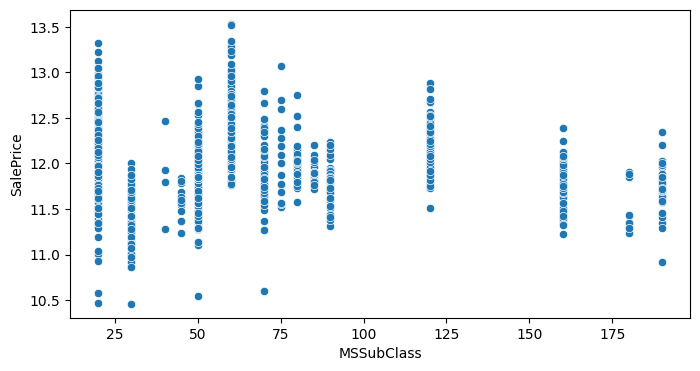

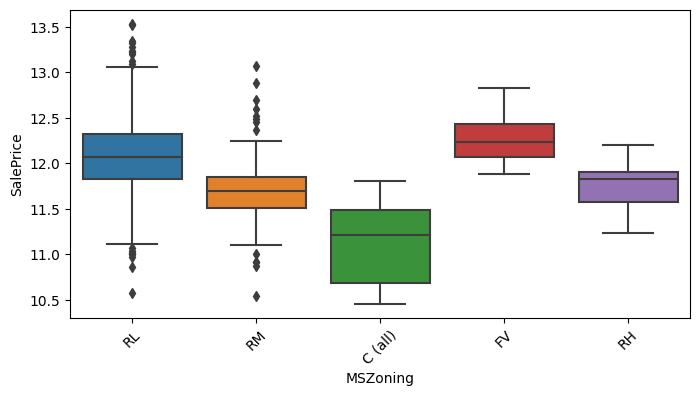

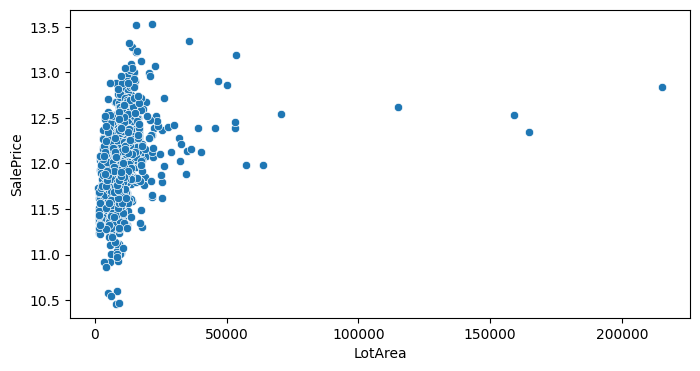

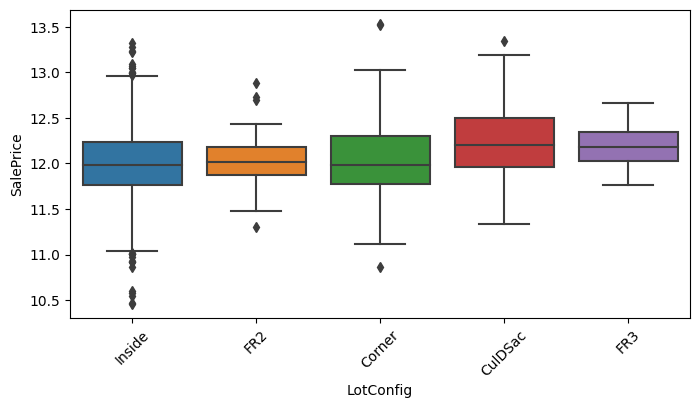

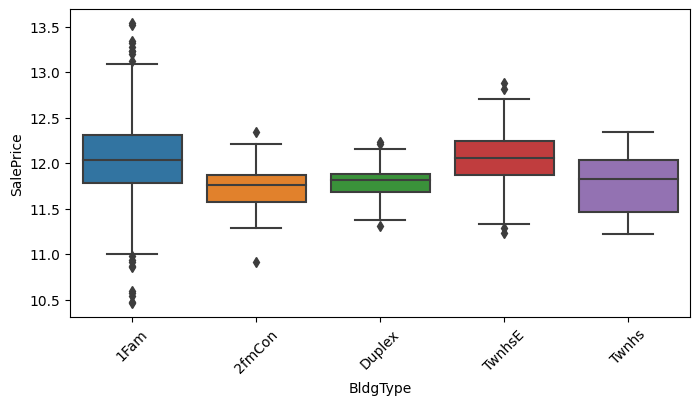

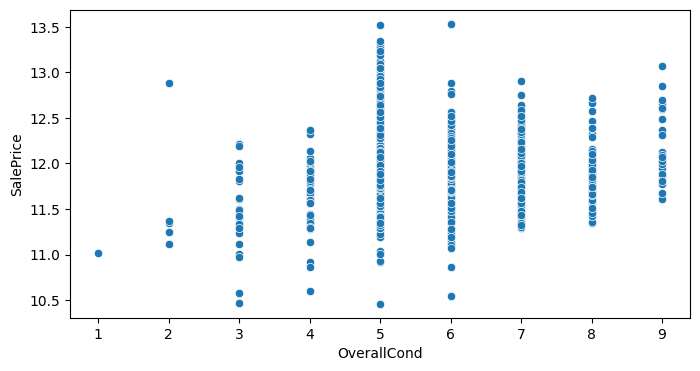

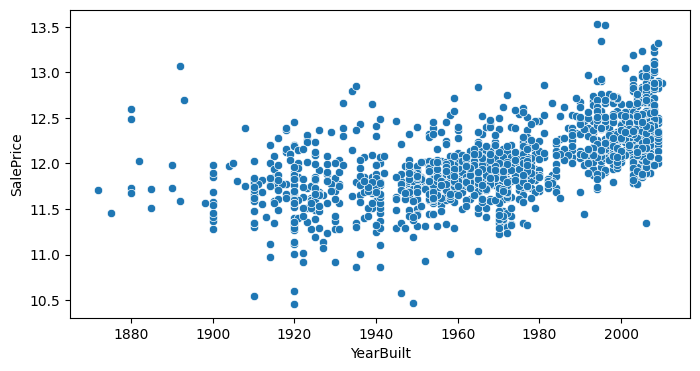

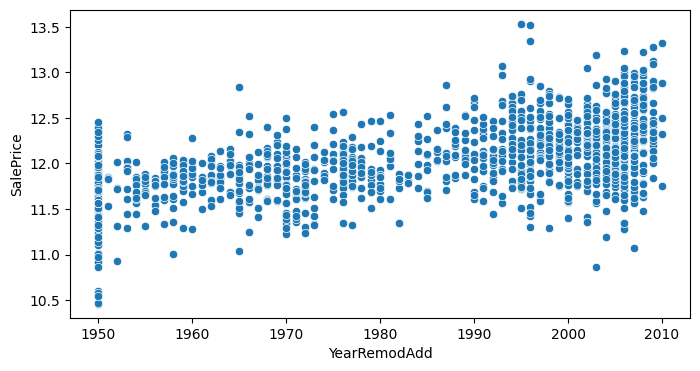

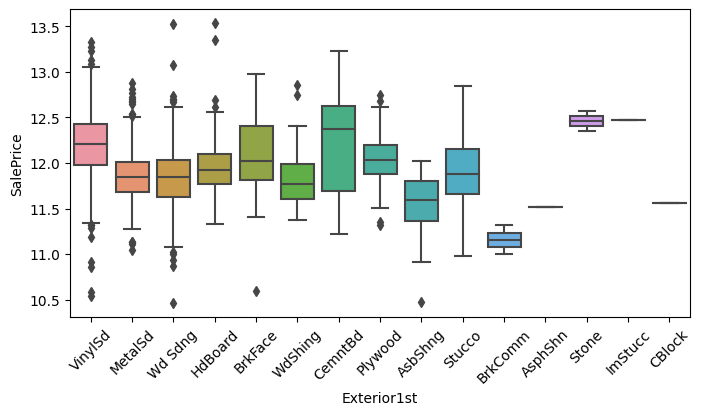

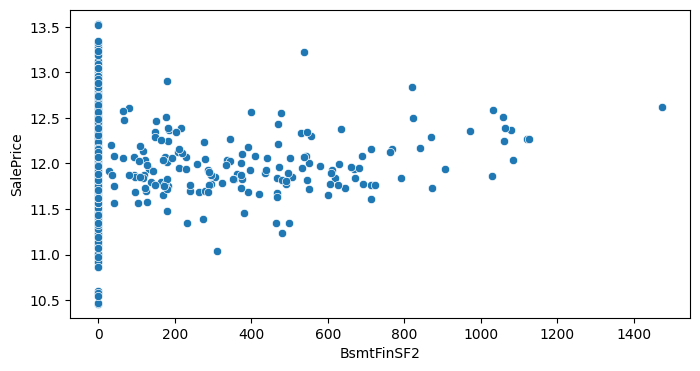

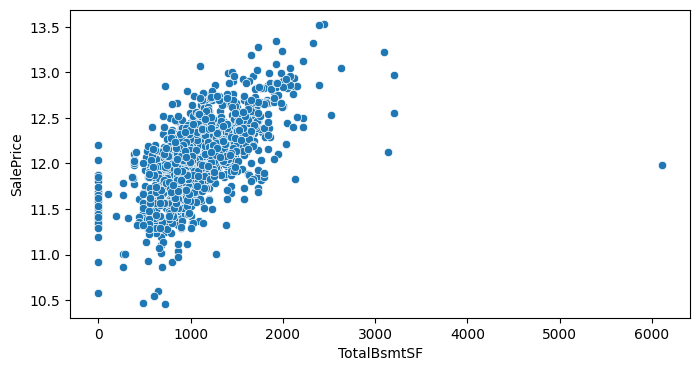

In [20]:
# Je supprime le prix du dataframe parcequ'il existe déjà dans la fonction
data_viz = df_house_price.drop('SalePrice', axis=1)
for col in data_viz.columns:
  plot_line(df_house_price[col])

*Visuellement, nous pouvons déceler des valeurs abérrantes de certaines colonnes par rapport au prix de vente comme :*
1. entre les attributs de type object et SalePrice : nous voyons des valeurs qui débordent les bornes inférieures et supérieures des boxplots
2. entre LotArea et SalePrice : nous constatons également 4  points qui s'éloignent des autres points
3. entre OverallCond et SalePrice : nous constatons la présence d'un point qui semble inhabituel en haut à gauche comparativement aux autres points ayant les mêmes caractéristiques
4. entre BsmtFinSF2, TotalBsmtSF et SalePrice : nous constatons la présence d'un point isolé qui est éloigné des autres dans chacun des cas.

## 3. Transformation des données

### 3.1 Encodage des attributs de type `object`

Les attributs de type `object` étant catégoriques (voire partie 1), on peut effectuer un `one hot encoding` de ces attributs. `Pandas` permet d'effectuer cela avec la fonction `get_dummies()`. Cela nous permettra d'obtenir un dataset contenant uniquement des attributs de type `int` ou `float`.


#### 3.1.1 Question 8

**Encodez les attributs de type `object` avec un `one hot encoding`**

In [21]:
df_house_price_encoded = pd.get_dummies(df_house_price)
df_house_price_encoded

,MSSubClass,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,MSZoning_C (all),MSZoning_FV,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
0,60,8450,5,2003,2003,0.0,856.0,12.247694,0,0,...,0,0,0,0,0,0,0,1,0,0
1,20,9600,8,1976,1976,0.0,1262.0,12.109011,0,0,...,0,0,0,1,0,0,0,0,0,0
2,60,11250,5,2001,2002,0.0,920.0,12.317167,0,0,...,0,0,0,0,0,0,0,1,0,0
3,70,9550,5,1915,1970,0.0,756.0,11.849398,0,0,...,0,0,0,0,0,0,0,0,1,0
4,60,14260,5,2000,2000,0.0,1145.0,12.429216,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,1936,7,1970,1970,0.0,546.0,NaN,0,0,...,1,0,0,0,0,0,0,0,0,0
2915,160,1894,5,1970,1970,0.0,546.0,NaN,0,0,...,1,0,0,0,0,0,0,0,0,0
2916,20,20000,7,1960,1996,0.0,1224.0,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0
2917,85,10441,5,1992,1992,0.0,912.0,NaN,0,0,...,0,1,0,0,0,0,0,0,0,0


In [22]:
df_house_price_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 0 to 2918
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MSSubClass           2913 non-null   int64  
 1   LotArea              2913 non-null   int64  
 2   OverallCond          2913 non-null   int64  
 3   YearBuilt            2913 non-null   int64  
 4   YearRemodAdd         2913 non-null   int64  
 5   BsmtFinSF2           2913 non-null   float64
 6   TotalBsmtSF          2913 non-null   float64
 7   SalePrice            1460 non-null   float64
 8   MSZoning_C (all)     2913 non-null   uint8  
 9   MSZoning_FV          2913 non-null   uint8  
 10  MSZoning_RH          2913 non-null   uint8  
 11  MSZoning_RL          2913 non-null   uint8  
 12  MSZoning_RM          2913 non-null   uint8  
 13  LotConfig_Corner     2913 non-null   uint8  
 14  LotConfig_CulDSac    2913 non-null   uint8  
 15  LotConfig_FR2        2913 non-null   u

### 3.2 Normalisation des données

Pour faciliter l'entraînement du modèle, on peut normaliser les données. `sklearn` permet d'effectuer cela avec les fonctions suivantes :

*   `StandardScaler()` normalise les données en soustrayant la moyenne et en divisant par l'écart-type
*   `MinMaxScaler()` normalise les données en les ramenant entre 0 et 1.

Dans la suite de ce TP, nous utiliserons la fonction `StandardScaler()`.

In [23]:
# # A utiliser dans la partie 6.2
# mu_sale_price = df_house_price_encoded["SalePrice"].mean()
# sigma_sale_price = df_house_price_encoded["SalePrice"].std()

#### 3.2.1 Question 9

**Implémenter la fonction `normalize`. Elle doit réaliser la normalisation des données.**

In [24]:
def normalize(dataset):
    scaler = preprocessing.StandardScaler()
    df_house_price_encoded_scaled = scaler.fit_transform(dataset)
    return df_house_price_encoded_scaled

In [25]:
house_price_normalized = normalize(df_house_price_encoded)

In [26]:
house_price_normalized

array([[ 0.06606554, -0.21550392, -0.51116217, ...,  1.35718504,
        -0.40415178, -0.1400035 ],
       [-0.87443011, -0.06865643,  2.19449876, ..., -0.73681921,
        -0.40415178, -0.1400035 ],
       [ 0.06606554,  0.14203779, -0.51116217, ...,  1.35718504,
        -0.40415178, -0.1400035 ],
       ...,
       [-0.87443011,  1.25935561,  1.29261179, ...,  1.35718504,
        -0.40415178, -0.1400035 ],
       [ 0.65387533,  0.03873377, -0.51116217, ..., -0.73681921,
        -0.40415178, -0.1400035 ],
       [ 0.06606554, -0.06520871, -0.51116217, ..., -0.73681921,
        -0.40415178, -0.1400035 ]])

In [31]:
df_house_price_normalized = pd.DataFrame(data=house_price_normalized, columns=df_house_price_encoded.columns)
df_house_price_normalized

,MSSubClass,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,MSZoning_C (all),MSZoning_FV,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
0,0.066066,-0.215504,-0.511162,1.044791,0.895701,-0.293353,-0.447678,0.560068,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
1,-0.874430,-0.068656,2.194499,0.152334,-0.398557,-0.293353,0.475862,0.212764,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,2.342595,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2,0.066066,0.142038,-0.511162,0.978683,0.847765,-0.293353,-0.302095,0.734046,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
3,0.301189,-0.075041,-0.511162,-1.863958,-0.686170,-0.293353,-0.675151,-0.437382,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,2.474318,-0.140004
4,0.066066,0.526395,-0.511162,0.945629,0.751894,-0.293353,0.209719,1.014651,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,2.417305,-1.047299,1.292612,-0.045990,-0.686170,-0.293353,-1.152843,NaN,-0.09304,-0.223848,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2909,2.417305,-1.052662,-0.511162,-0.045990,-0.686170,-0.293353,-1.152843,NaN,-0.09304,-0.223848,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2910,-0.874430,1.259356,1.292612,-0.376529,0.560152,-0.293353,0.389422,NaN,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
2911,0.653875,0.038734,-0.511162,0.681198,0.368411,-0.293353,-0.320293,NaN,-0.09304,-0.223848,...,-0.212626,2.364423,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004


## 4. Sélection des attributs

### 4.1 Suppression des attributs corrélées

Pour améliorer la qualité de la prédiction, nous devons prendre en compte la corrélation entre attributs. L'objectif est donc de supprimer les attributs les plus fortement corrélées entre eux.

Pour ce faire, vous disposez des fonctions suivantes

* `corr()` de `Pandas` qui calcule la matrice de corrélation
* `heatmap()` de `seaborn` qui permet de visualiser la matrice de corrélation


#### 4.1.1 Question 10

**Implémenter la fonction `display_corr_matrix`. Elle doit permettre d'afficher la matrice de corrélation entre les différents attributs de nos données normalisées.**

In [65]:
def display_corr_matrix(dataset):
  plt.figure(figsize=(30, 20), dpi=100)
  plt.title("Corrélation entre les différents attributs")
  sns.heatmap(data=dataset.corr(), annot=True, fmt=".2f", cmap='magma');

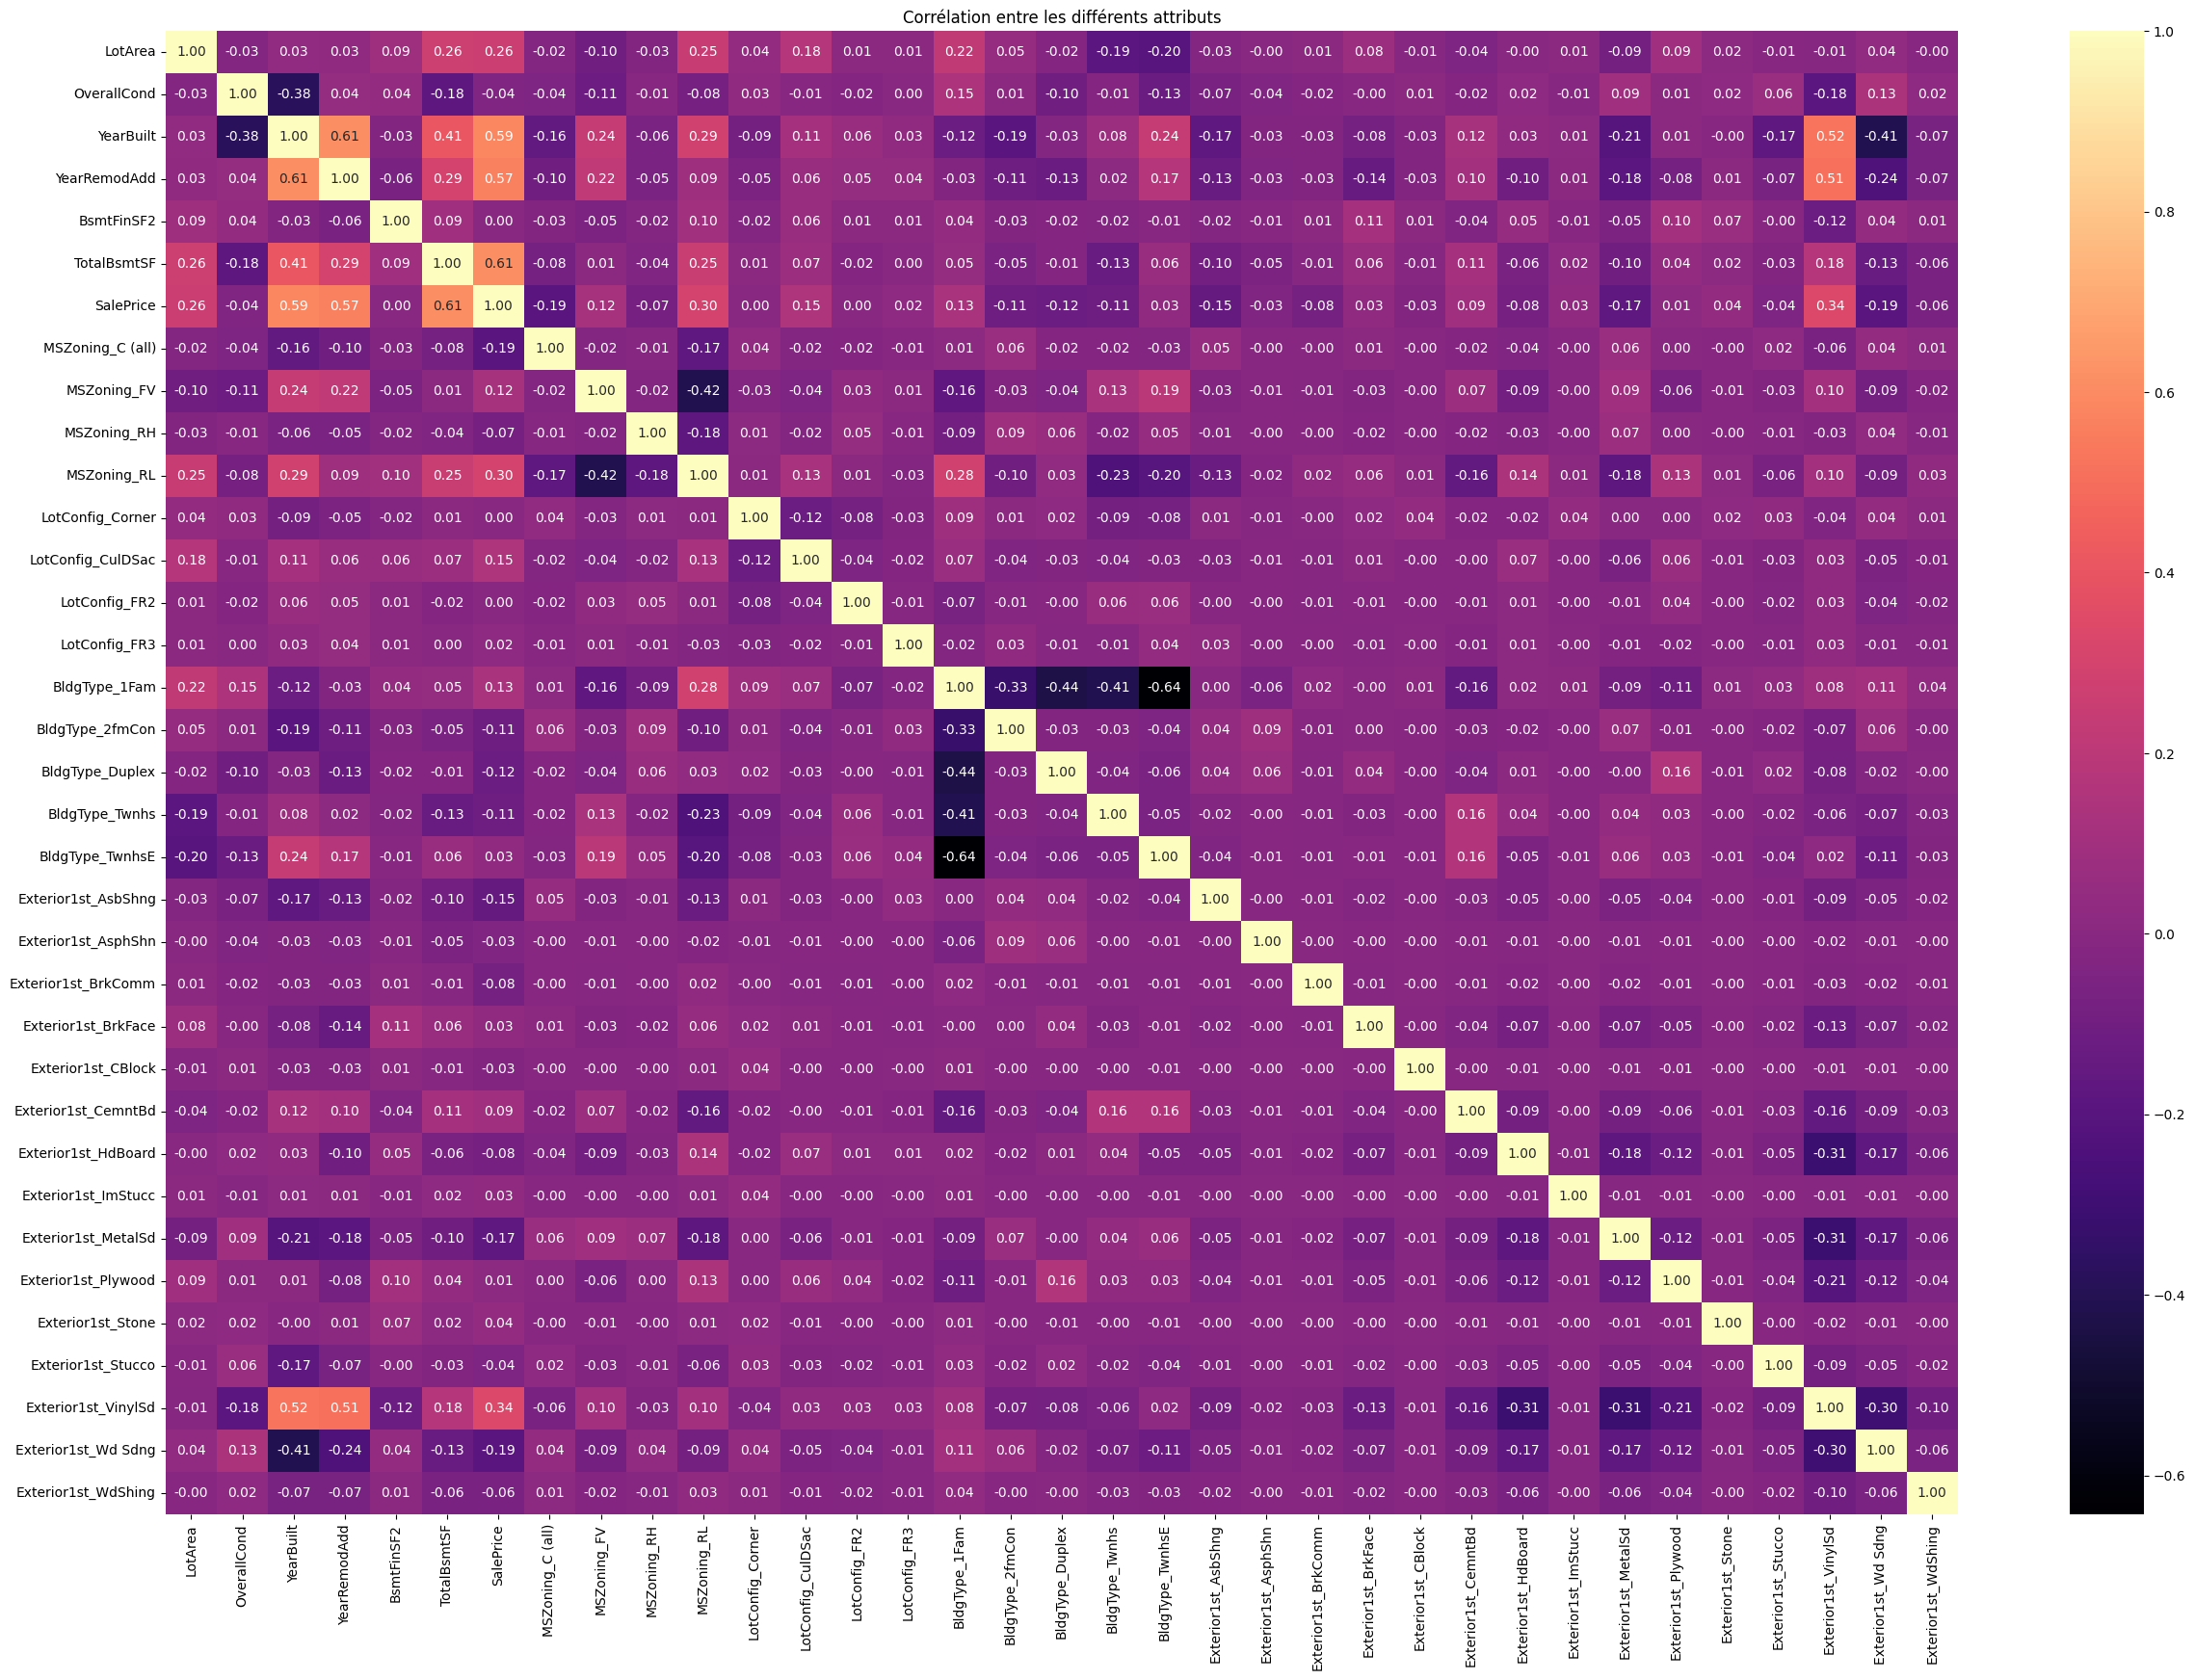

In [66]:
display_corr_matrix(df_house_price_normalized)

In [62]:
df_house_price_normalized.corr()['SalePrice'].sort_values(ascending=False)

SalePrice              1.000000
TotalBsmtSF            0.612134
YearBuilt              0.586570
YearRemodAdd           0.565608
Exterior1st_VinylSd    0.336138
MSZoning_RL            0.298862
LotArea                0.257320
LotConfig_CulDSac      0.148309
BldgType_1Fam          0.132469
MSZoning_FV            0.120312
Exterior1st_CemntBd    0.094582
Exterior1st_Stone      0.040114
Exterior1st_BrkFace    0.030223
Exterior1st_ImStucc    0.029638
BldgType_TwnhsE        0.025800
LotConfig_FR3          0.022529
Exterior1st_Plywood    0.012151
LotConfig_FR2          0.004883
BsmtFinSF2             0.004832
LotConfig_Corner       0.003985
Exterior1st_CBlock    -0.030312
Exterior1st_AsphShn   -0.033511
OverallCond           -0.036868
Exterior1st_Stucco    -0.043651
Exterior1st_WdShing   -0.060532
MSZoning_RH           -0.072285
MSSubClass            -0.073959
Exterior1st_HdBoard   -0.076516
Exterior1st_BrkComm   -0.080301
LotConfig_Inside      -0.089076
BldgType_Twnhs        -0.109125
BldgType

#### 4.1.2 Question 11

On peut alors choisir de supprimer les attributs qui sont fortement corrélées entre eux en définissant un seuil. Fixons ce seuil à 0.7.

**Quels sont les attributs fortement correlés selon le critère ci-dessus ? Supprimez ces attributs et affichez la nouvelle matrice de corrélation.**

*D'après nos différentes observations sur le graphique ci-dessus, nous voyons que certains attributs sont corrélés avec d'autres attributs en dehors de l'attribut SalePrice avec des corrélations fortes négatives.*

**Les attributs fortements corrélés : BldgType_1Fam et MSSubClass (-0.81), MSZoning_RM et MSZoning_RL (-0.81), LotConfig_Inside et LotConfig_Corner (-0.76).**

In [63]:
# Suppression des attributs fortement corrélés (1 attribut par paire de corrélation)
# Je vais supprimer les attributs qui ont une faible corrélation avec SalePrice et qui sont plus corrélés avec d'autres attributs d'après le résultat précédent
df_house_price_normalized = df_house_price_normalized.drop(["MSSubClass", "MSZoning_RM", "LotConfig_Inside"], axis=1)

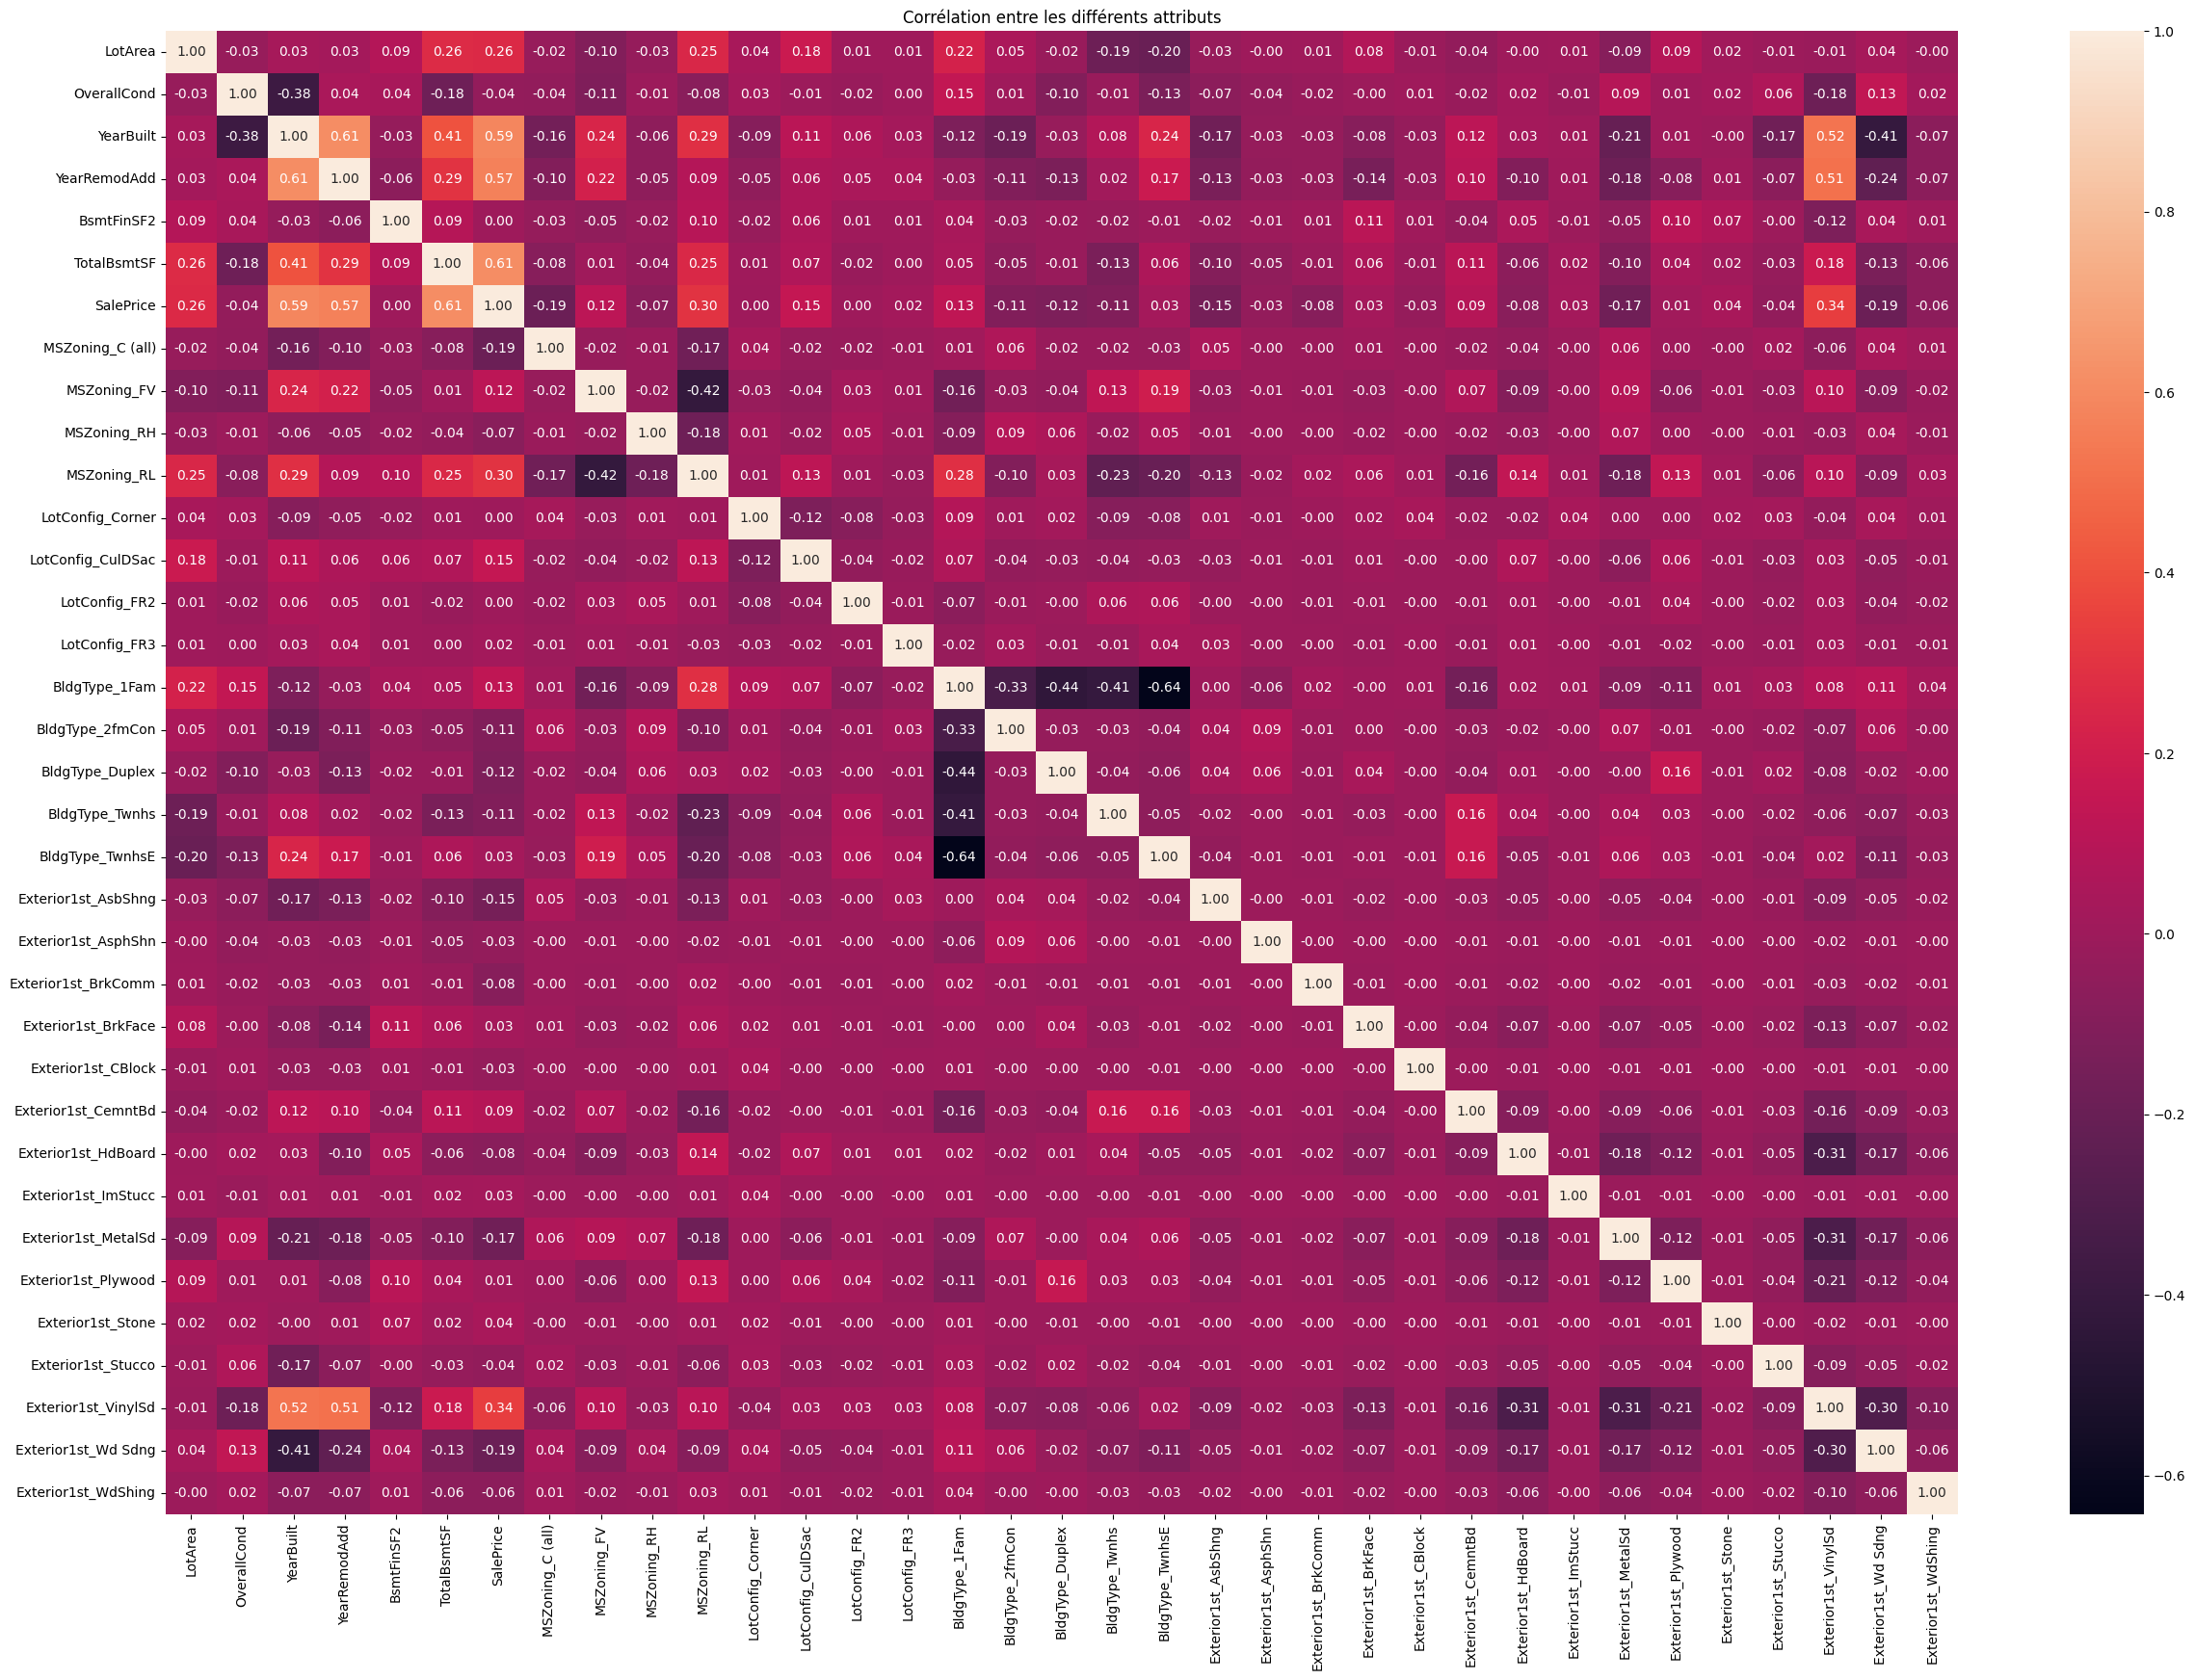

In [64]:
display_corr_matrix(df_house_price_normalized)

## 5. Récapitulatif des prétraitements

<img src=" 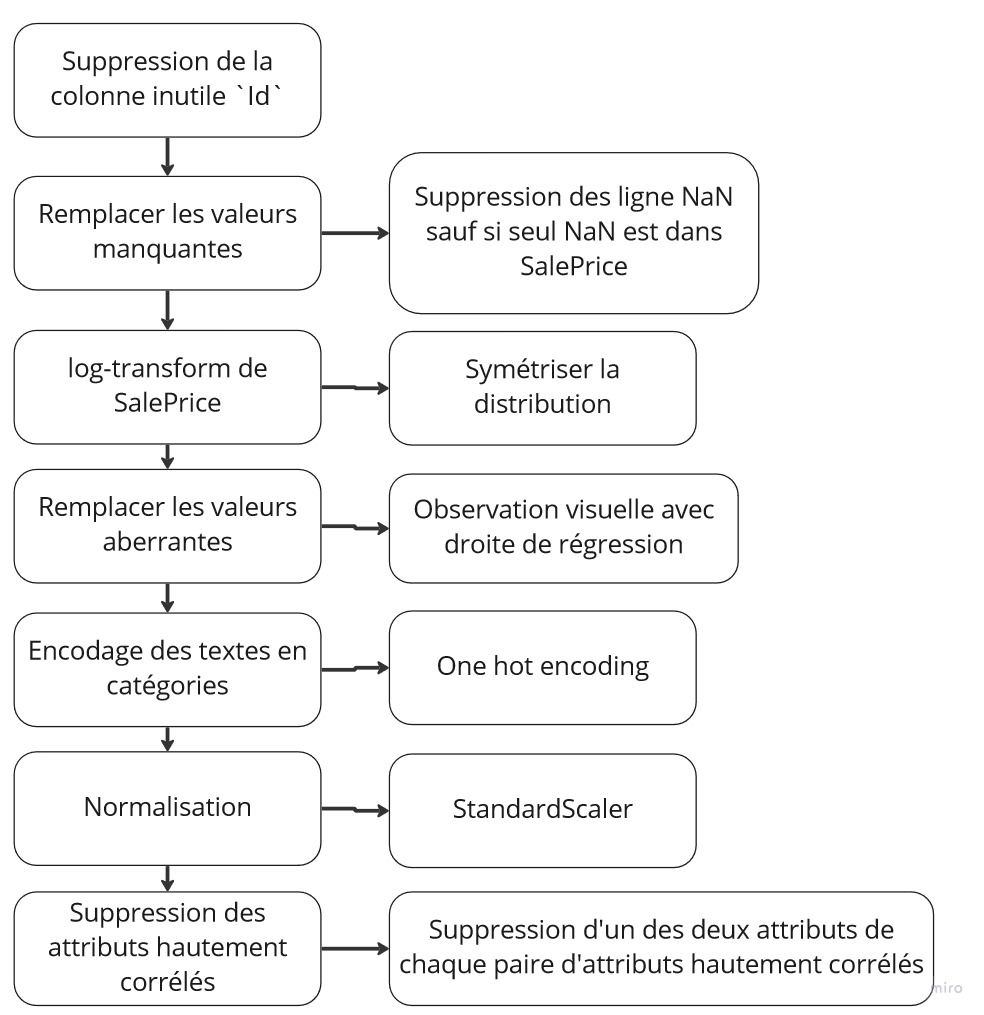" height="600px">

## 6. Entrainement d'un modèle de régression linéaire

### 6.1 Rappel du concept

La régression linéaire consiste à trouver une fonction affine qui minimise la somme des carrés des erreurs. La fonction affine est définie par la formule suivante :
$$ f(x) = \beta_0 + \beta_1 x $$
Nous tentons de trouver les paramètres $\beta_0$ et $\beta_1$ qui minimisent $\sum_{i=1}^n (f(x_i) - y_i)^2=||y-X\beta||^2$ où $X$ est la matrice des données fournies au modèle et $y$ le vecteur des `SalePrice`.

On veut trouver le minimum de cette fonction. On va utiliser `RidgeRegression` de `sklearn` pour trouver les paramètres $\beta_0$ et $\beta_1$. Ce module utilise la méthode des moindres carrés (`numpy.linalg.lstsq`) pour trouver les paramètres $\beta_0$ et $\beta_1$.

### 6.2 Application

#### 6.2.1 Question 12

Après avoir effectué le prétraitement, on peut commencer par séparer les données en un ensemble d'entraînement et un ensemble de test. Pour cela, les 1460 premières lignes contiennent les données d'entrainement. On peut ainsi séparer les données en deux ensembles.

**Compléter la structure suivante afin de diviser les données en deux sous-ensembles.**

In [73]:
df_house_price_normalized[1460:]

,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
1460,0.189540,0.390725,-0.343475,-1.117590,0.557162,-0.388535,NaN,-0.09304,-0.223848,10.537479,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
1461,0.527289,0.390725,-0.442637,-1.261396,-0.293353,0.628268,NaN,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,2.474318,-0.140004
1462,0.471487,-0.511162,0.846467,0.656023,-0.293353,-0.283897,NaN,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
1463,-0.020388,0.390725,0.879521,0.656023,-0.293353,-0.288447,NaN,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
1464,-0.655408,-0.511162,0.681198,0.368411,-0.293353,0.516807,NaN,-0.09304,-0.223848,-0.094899,...,-0.212626,2.364423,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,-1.047299,1.292612,-0.045990,-0.686170,-0.293353,-1.152843,NaN,-0.09304,-0.223848,-0.094899,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2909,-1.052662,-0.511162,-0.045990,-0.686170,-0.293353,-1.152843,NaN,-0.09304,-0.223848,-0.094899,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2910,1.259356,1.292612,-0.376529,0.560152,-0.293353,0.389422,NaN,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
2911,0.038734,-0.511162,0.681198,0.368411,-0.293353,-0.320293,NaN,-0.09304,-0.223848,-0.094899,...,-0.212626,2.364423,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004


In [77]:
X_train = df_house_price_normalized.drop("SalePrice", axis=1)[:1460]
y_train = df_house_price_normalized["SalePrice"][:1460]

X_test = df_house_price_normalized.drop("SalePrice", axis=1)[1460:]

data_train = {"x": X_train, "y": y_train, "df": df_house_price_normalized[:1460]}
data_pred = {"x": X_test, "df": df_house_price_normalized[1460:]}

In [78]:
print("Le nombre de lignes d'entrainement : ", len(data_train['x']), " ********* Le nombre de lignes de test : ", len(data_pred['x']))

Le nombre de lignes d'entrainement :  1460  ********* Le nombre de lignes de test :  1453


#### 6.2.2 Question 13

Une fois cette scission faite, on peut utiliser `RidgeRegression` pour effectuer la régression linéaire avec pénalisation de la norme L2.

**Compléter la fonction `ridge_regression`. Elle doit implémenter l'ensemble de la régression.**

*Pour cette question, vous devez retourner les coefficients de la regression linéaire. De plus, cette fonction doit modifier le paramètre `data_pred` en y ajoutant les valeurs prédites. Il est aussi nécéssaire de prendre en compte certaines modifications effectuées lors de la transformation des données*

In [82]:
def ridge_regression(data_train, data_pred):
    ridge_model = linear_model.Ridge()
    ridge_model.fit(data_train['x'], data_train['y'])
    y_pred = ridge_model.predict(data_pred['x'])

    data_pred["y"] = y_pred

    return ridge_model.coef_

In [83]:
 reg_ridge = ridge_regression(data_train, data_pred)
 data_pred["y"]

array([-0.45575792,  0.03609762,  0.35464731, ...,  0.44531135,
        0.05210341,  0.14611015])

#### 6.2.3 Question 14

**Comparer la distribution des données prédites avec celles d'entrainement.**

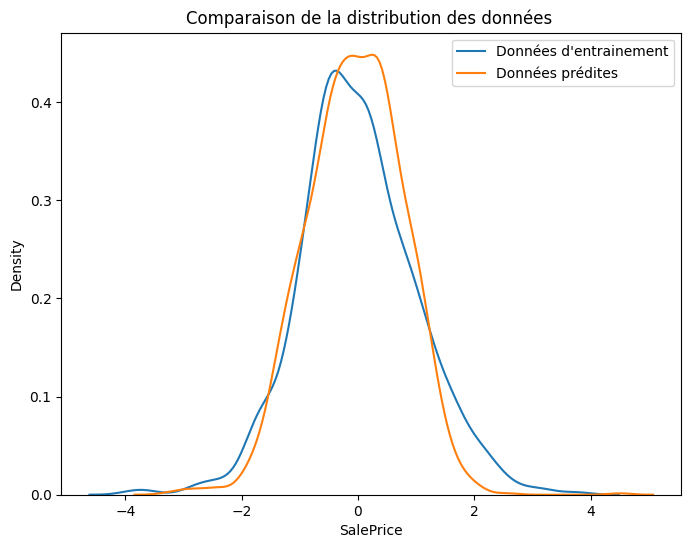

In [88]:
plt.figure(figsize=(8, 6), dpi=100)
plt.title("Comparaison de la distribution des données ")
sns.kdeplot(data_train['y'])
sns.kdeplot(data_pred['y'])
plt.legend(["Données d'entrainement", "Données prédites"]);

**Note :** *nous observons que les valeurs prédites suivent une distribution normale presque parfaite comparativement aux valeurs d'entrainement qui ont été ajustées par logarithme. Il arrive à bien prédire les prix.*

In [90]:
data_train['x'].columns

Index(['LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF2',
       'TotalBsmtSF', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'Exterior1st_AsbShng',
       'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace',
       'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard',
       'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood',
       'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd',
       'Exterior1st_Wd Sdng', 'Exterior1st_WdShing'],
      dtype='object')

In [96]:
# Remplacement des valeurs NaN dans SalePrice pour les données de test par les valeurs prédites
data_pred["df"]['SalePrice'] = data_pred['y']

<ipython-input-96-efd5d0f5430e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred["df"]['SalePrice'] = data_pred['y']


In [102]:
# Construction du dataframe global avec toutes les valeurs des prix de ventes
df_full_house_price = pd.concat([data_train['df'], data_pred['df']])
df_full_house_price

,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
0,-0.215504,-0.511162,1.044791,0.895701,-0.293353,-0.447678,0.560068,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
1,-0.068656,2.194499,0.152334,-0.398557,-0.293353,0.475862,0.212764,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,2.342595,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2,0.142038,-0.511162,0.978683,0.847765,-0.293353,-0.302095,0.734046,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
3,-0.075041,-0.511162,-1.863958,-0.686170,-0.293353,-0.675151,-0.437382,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,2.474318,-0.140004
4,0.526395,-0.511162,0.945629,0.751894,-0.293353,0.209719,1.014651,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,-1.047299,1.292612,-0.045990,-0.686170,-0.293353,-1.152843,-0.986232,-0.09304,-0.223848,-0.094899,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2909,-1.052662,-0.511162,-0.045990,-0.686170,-0.293353,-1.152843,-1.011716,-0.09304,-0.223848,-0.094899,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2910,1.259356,1.292612,-0.376529,0.560152,-0.293353,0.389422,0.445311,-0.09304,-0.223848,-0.094899,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
2911,0.038734,-0.511162,0.681198,0.368411,-0.293353,-0.320293,0.052103,-0.09304,-0.223848,-0.094899,...,-0.212626,2.364423,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004


#### 6.2.4 Question 15

Une fois la prédiction obtenue, on peut maintenant mesurer l'importance de chaque attribut dans la prédicition.

**Quels sont les dix attributs ayant le plus d'impact dans la prédiction ?**


In [103]:
reg_ridge

array([ 8.54538009e-02,  1.20573734e-01,  3.41340866e-01,  2.29407806e-01,
       -3.68946241e-02,  3.64317745e-01, -9.21517678e-02,  8.08340419e-02,
        1.83623545e-02,  8.64424089e-02,  2.37650370e-02,  3.70504647e-02,
       -1.01069273e-02,  1.11929277e-02,  5.45973662e-02,  2.57133195e-02,
       -2.83576458e-02, -5.61895083e-02, -3.27802925e-02, -4.34669845e-03,
        4.80766892e-03, -5.07139001e-02,  6.35298710e-02, -2.08472287e-03,
        3.15769415e-02, -5.13724950e-02,  3.82645943e-03, -2.48328872e-03,
       -3.08213504e-03,  1.90364931e-02,  2.73069480e-02, -6.34368388e-03,
        1.38077833e-02,  8.53392882e-05])

In [107]:
# Je vais transformer les coefficients du modèle en dataframe à une seule colonne
df_reg_coef = pd.DataFrame(data=reg_ridge, index=X_train.columns, columns=['Coefficients'])
df_reg_coef

,Coefficients
LotArea,0.085454
OverallCond,0.120574
YearBuilt,0.341341
YearRemodAdd,0.229408
BsmtFinSF2,-0.036895
TotalBsmtSF,0.364318
MSZoning_C (all),-0.092152
MSZoning_FV,0.080834
MSZoning_RH,0.018362
MSZoning_RL,0.086442


In [110]:
# Je vais sélectionner les 10 attributs ayant le plus d'impact
print("Les 10 attributs ayant le plus d'impact")
df_reg_coef.nlargest(10, columns=df_reg_coef.columns)

Les 10 attributs ayant le plus d'impact


,Coefficients
TotalBsmtSF,0.364318
YearBuilt,0.341341
YearRemodAdd,0.229408
OverallCond,0.120574
MSZoning_RL,0.086442
LotArea,0.085454
MSZoning_FV,0.080834
Exterior1st_BrkFace,0.063530
BldgType_1Fam,0.054597
LotConfig_CulDSac,0.037050


## 7. Bonus : méthode des écarts interquartiles ou IQR

On peut également détecter les valeurs aberrantes en affichant un boxplot de chaque colonne. `Plotly` considère les valeurs aberrantes comme des outliers si elles sont situées en dehors de l'intervalle [Q1 - α * IQR, Q3 + α * IQR] où
* Q1 et Q3 sont les quantiles 25% et 75%,
* IQR l'intervalle interquartile (Q3 - Q1)
* α le facteur d'ajustement.

On exclut `SalePrice` car les seules valeurs manquantes de cet attribut sont celles du dataset de test.

### 7.1 Question A

**A quelle valeur fixer le facteur d'ajustement α ? Combien y-a-t-il alors de données aberrantes pour chaque attribut ?**

***Je fixe le facteur d'ajustement α à 5.5, parcequ'à 1.5, j'ai remarqué la présence de beaucoup de valeurs aberrantes.***

In [131]:
def get_outliers(df_without_price):
  # Récupération de toutes les colonnes en excluant la colonne SalePrice
  df_without_price = df_without_price.drop('SalePrice', axis=1)

  # Récupération des quantiles et l'intervalle interquantile
  Q1 = df_without_price.quantile(0.25)
  Q3 = df_without_price.quantile(0.75)
  IQR = Q3 - Q1

  # Récupération des bornes (inférieures et supérieures)
  minimum = (Q1 - (5.5 * IQR))
  maximum = (Q3 + (5.5 * IQR))

  # Comptage du nombre de valeurs aberrantes pour chaque attribut
  outliers_inf = df_without_price[df_without_price < minimum].count()
  outliers_sup = df_without_price[df_without_price > maximum].count()
  number_outliers = outliers_inf + outliers_sup

  datas = [Q1, Q3, IQR, minimum, maximum, number_outliers]
  columns = ["Q1", "Q2", "IQR", "minimum", "maximum", "nombre_de_valeurs_aberrantes"]

  df_outliers_number = pd.DataFrame(data=datas, index=columns).transpose()

  return df_outliers_number

In [132]:
df_outliers = get_outliers(df_full_house_price)
df_outliers

,Q1,Q2,IQR,minimum,maximum,nombre_de_valeurs_aberrantes
LotArea,-0.339877,0.180729,0.520606,-3.203212,3.044063,28.0
OverallCond,-0.511162,0.390725,0.901887,-5.471541,5.351103,0.0
YearBuilt,-0.574853,0.978683,1.553536,-9.119303,9.523133,0.0
YearRemodAdd,-0.925848,0.943636,1.869484,-11.208011,11.225800,0.0
BsmtFinSF2,-0.293353,-0.293353,0.000000,-0.293353,-0.293353,347.0
TotalBsmtSF,-0.590986,0.566851,1.157836,-6.959086,6.934951,2.0
MSZoning_C (all),-0.093040,-0.093040,0.000000,-0.093040,-0.093040,25.0
MSZoning_FV,-0.223848,-0.223848,0.000000,-0.223848,-0.223848,139.0
MSZoning_RH,-0.094899,-0.094899,0.000000,-0.094899,-0.094899,26.0
MSZoning_RL,0.535407,0.535407,0.000000,0.535407,0.535407,649.0


### 7.2 Question B

**Traitez les données aberrantes identifiées à la question précédantes. Quel traitement appliquer ?**

In [130]:
df_outliers['nombre_de_valeurs_aberrantes'].sum()

4877.0

*Nous voyons qu'il y a plus de 4800 données aberrantes pour l'ensemble des attributs, cela peut-être dit par rapport à la distribution des valeurs des attributs ou à la transformation appliquée sur ceux-ci. Au lieu de supprimer les lignes impliquées, nous allons juste visualiser la distribution de chaque attribut pour nous décider du traitement à effectuer.*

In [133]:
df_full_without_price = df_full_house_price.drop("SalePrice", axis=1)

<ipython-input-127-6d013f93d201>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4), dpi=100)


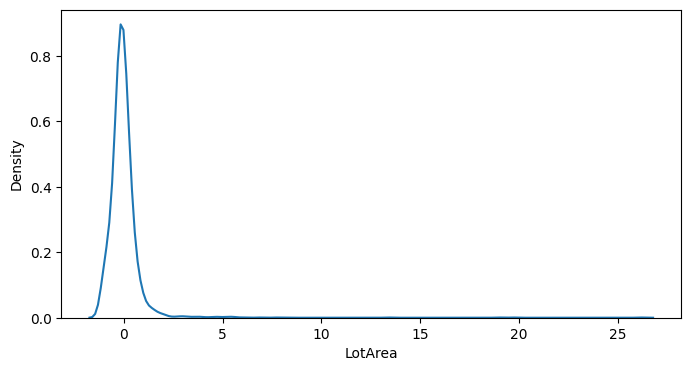

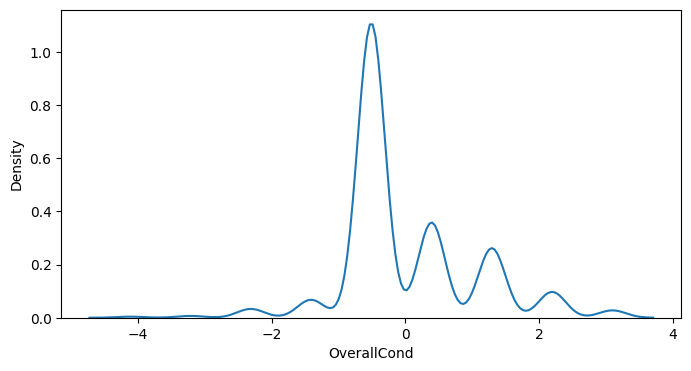

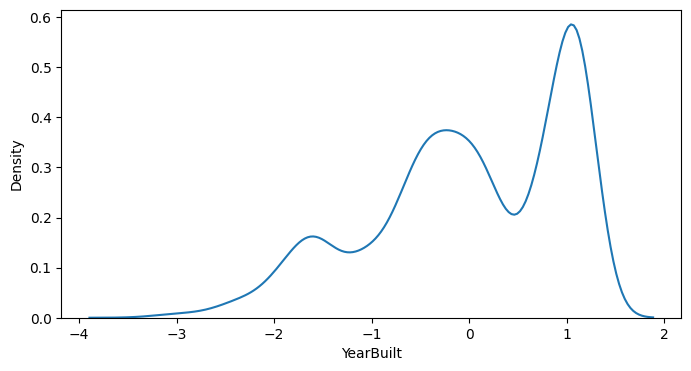

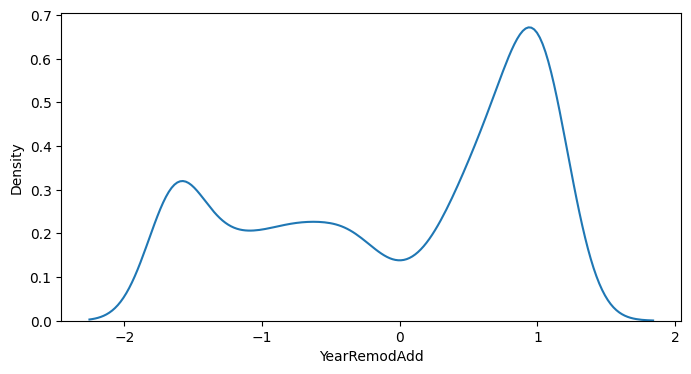

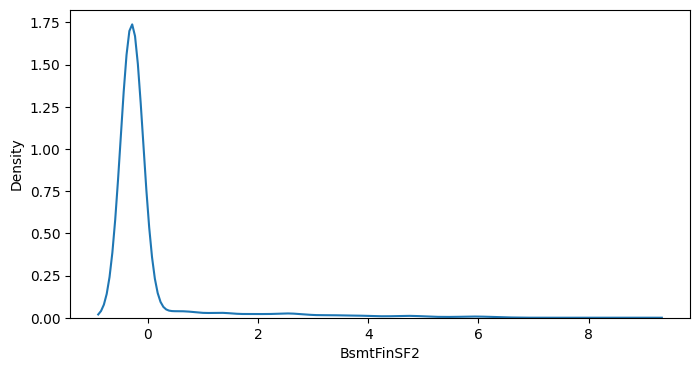

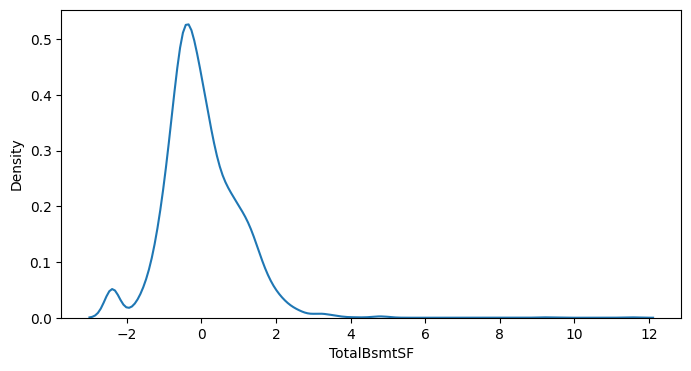

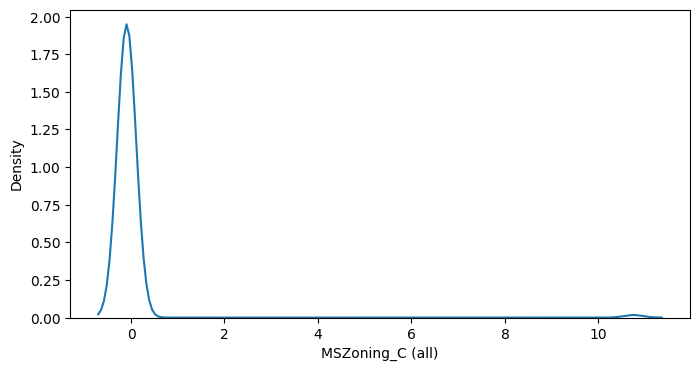

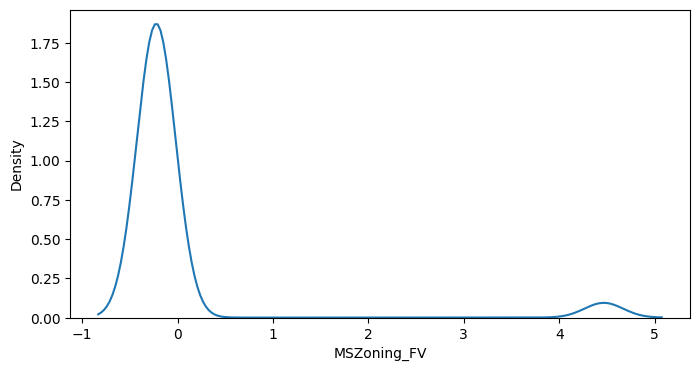

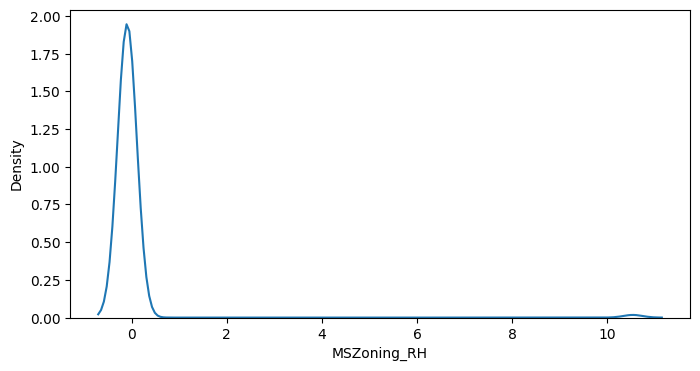

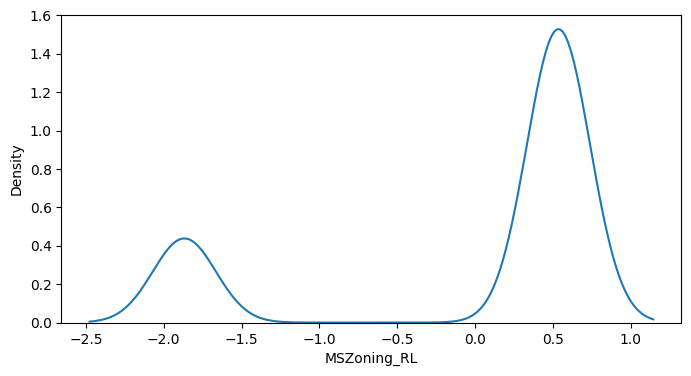

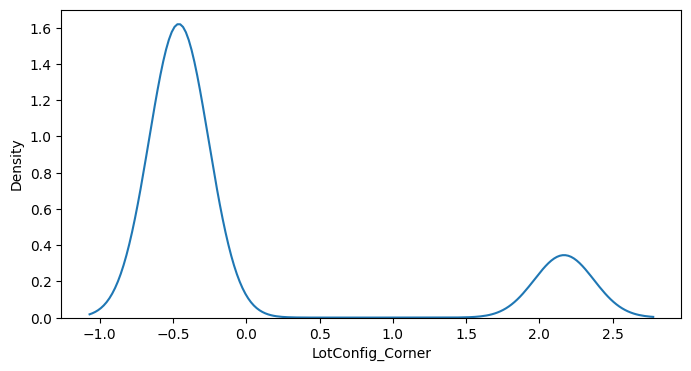

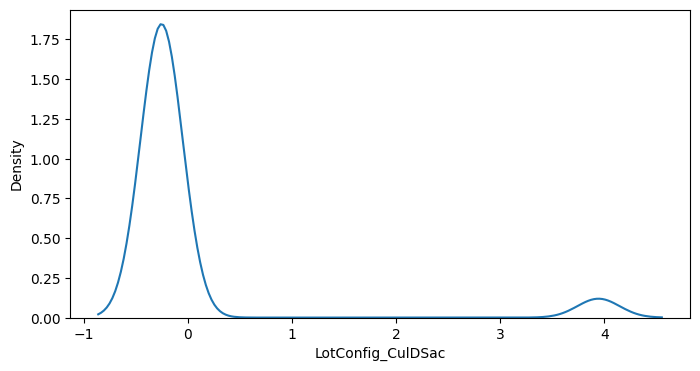

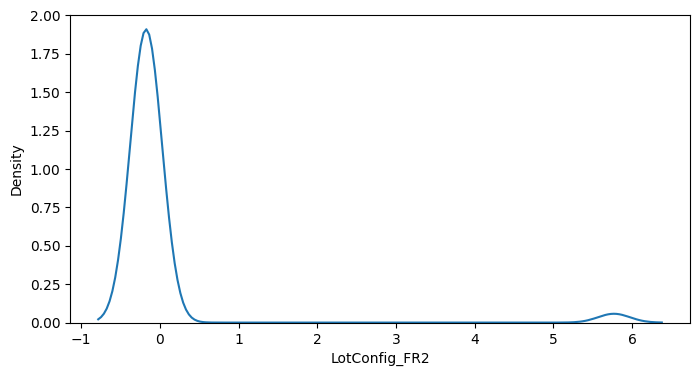

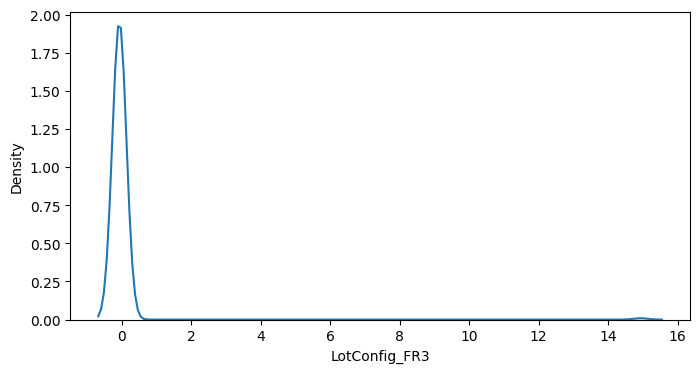

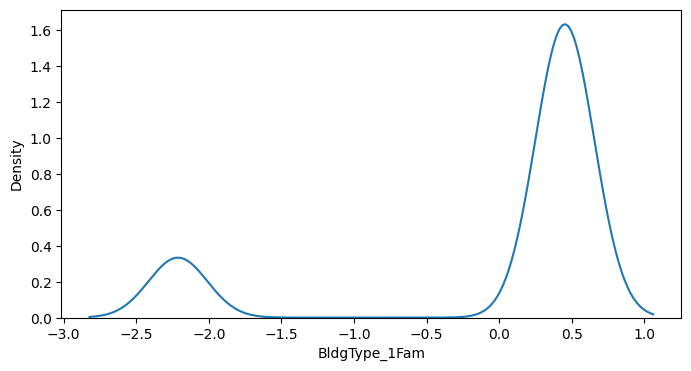

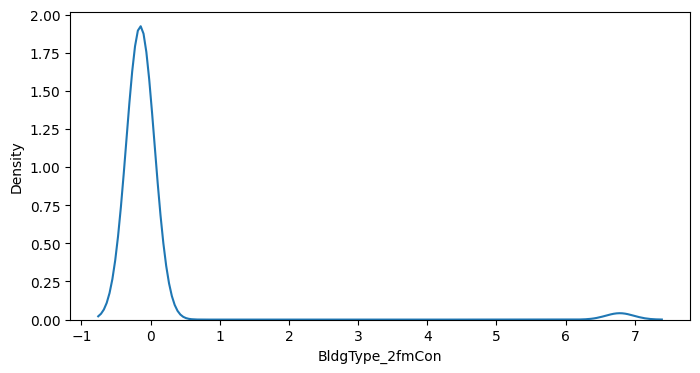

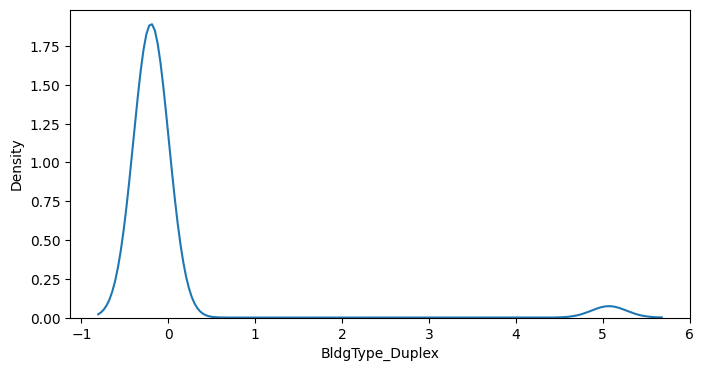

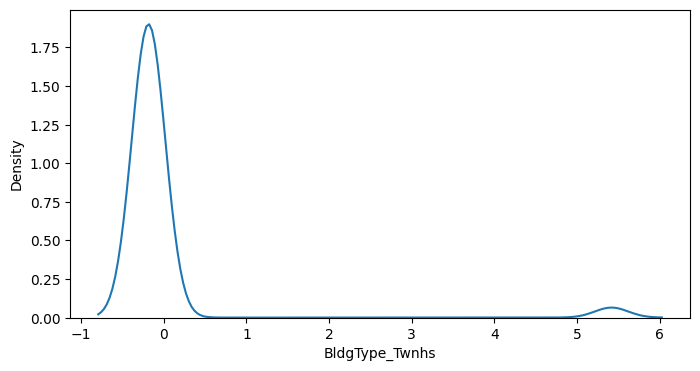

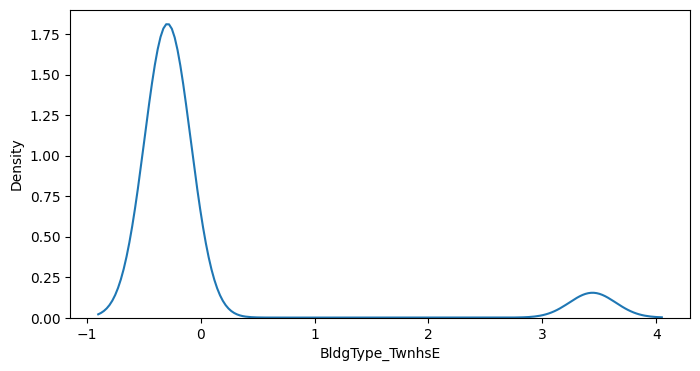

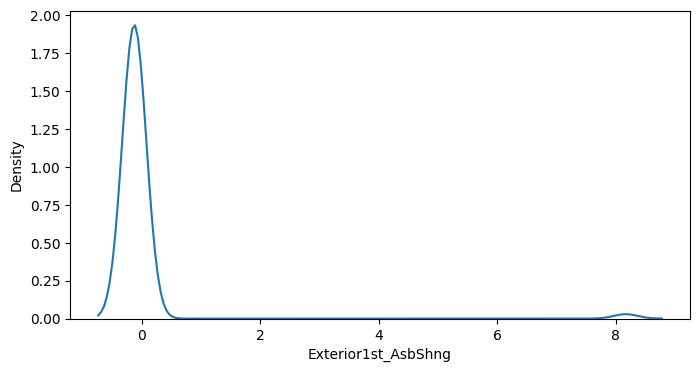

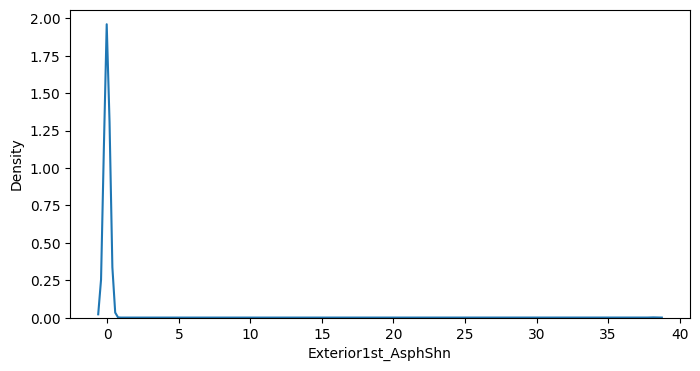

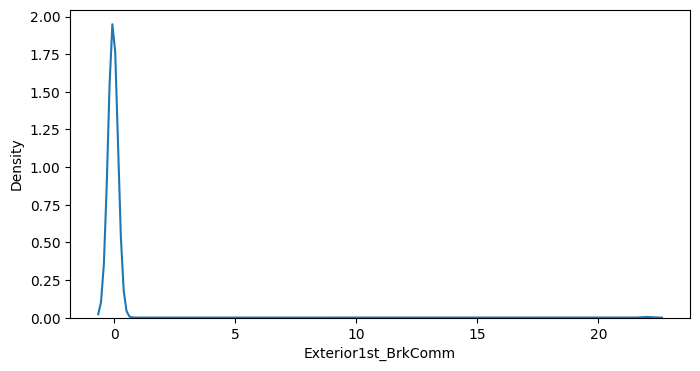

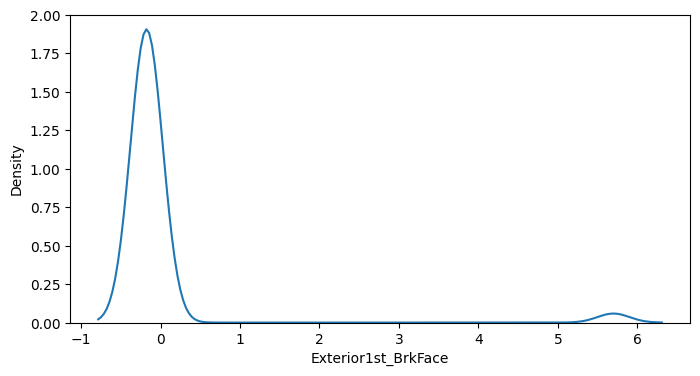

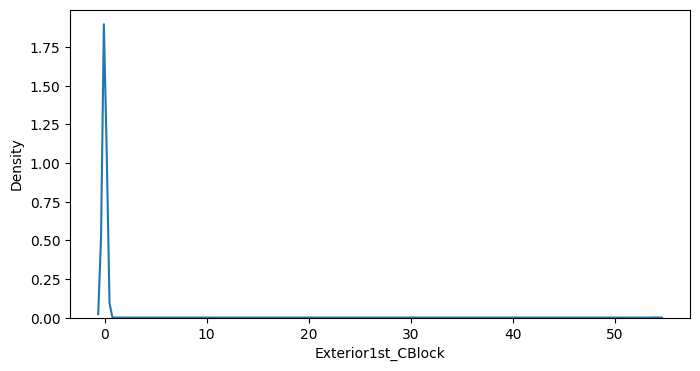

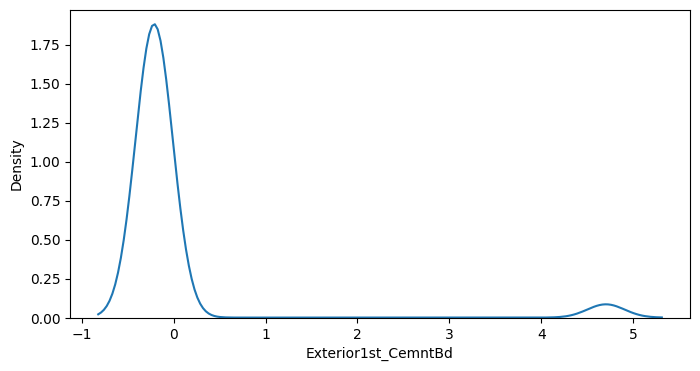

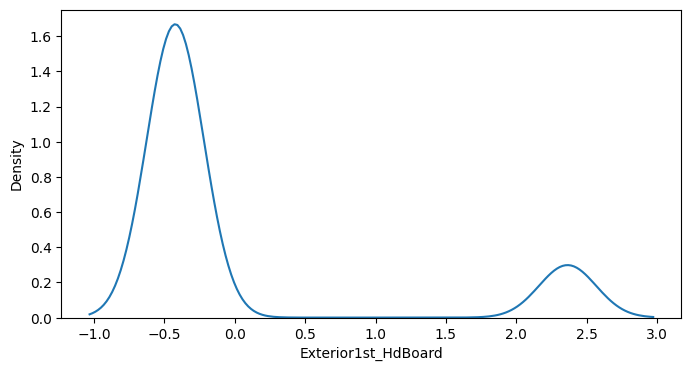

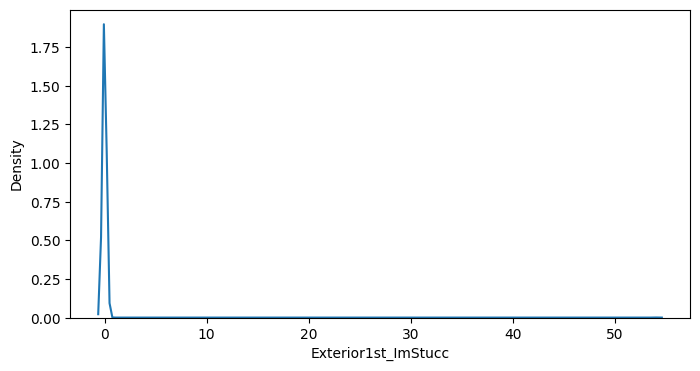

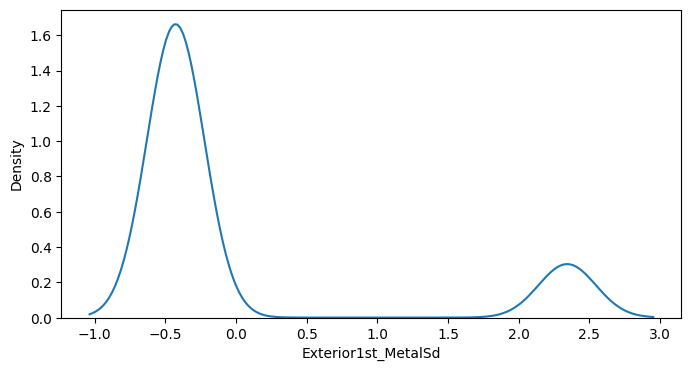

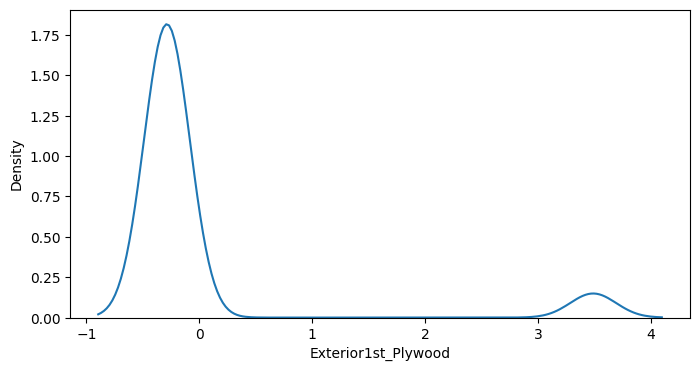

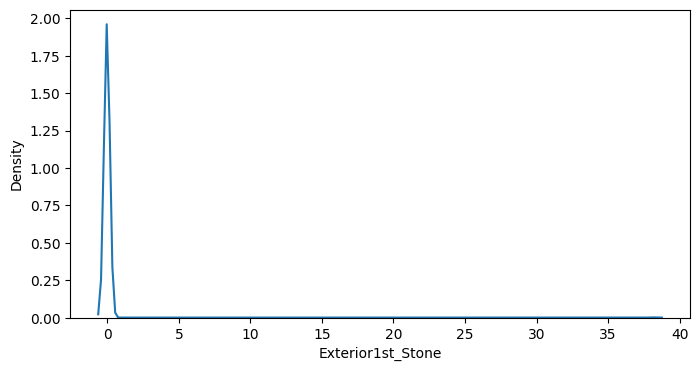

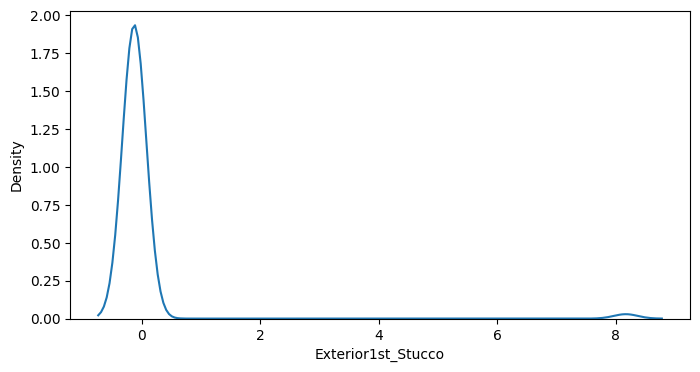

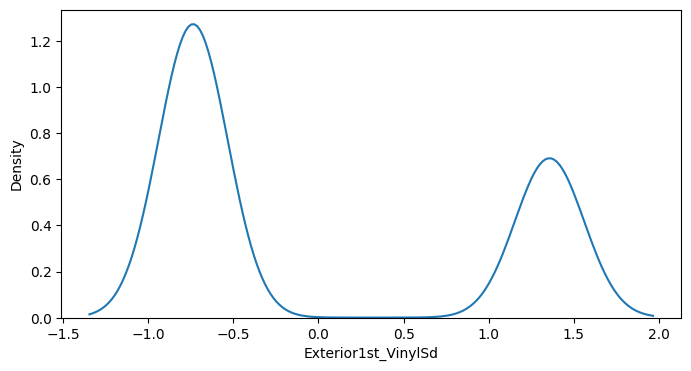

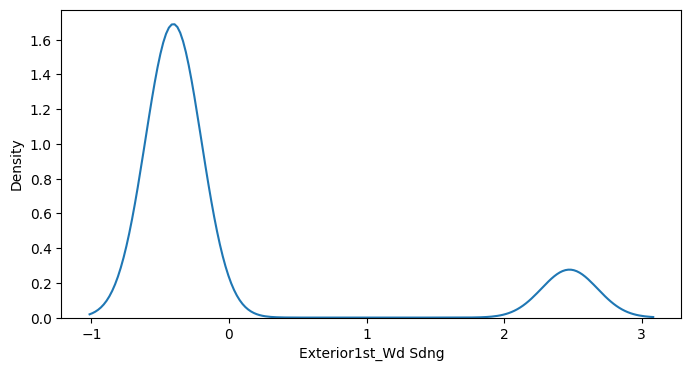

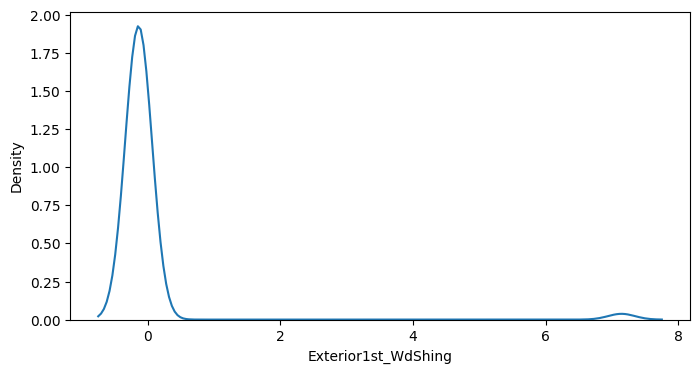

In [127]:
for i in df_full_without_price.columns:
  plt.figure(figsize=(8, 4), dpi=100)
  sns.kdeplot(df_full_without_price[i]);

**Note :** *Nous voyons que la distribution des attributs est asymétrique. Donc pour attenuer les valeurs aberrantes, comme les valeurs aberrantes sont nombreuses, au lieu de toutes les supprimer, je vais me fixer un seuil de tolérance et supprimer toutes lignes dont les valeurs depassent le seuil.*

---
**Note :** *Si nous observons le dataframe df_outliers_number, les attributs comportants le plus de valeurs aberrantes ont un IQR = 0 (donc minimum = maximum) et que la plus part de ces valeurs sont négatives. Donc je vais me fixer un seuil, depassé ce seuil, les valeurs sont supprimées du dataframe.*

In [134]:
# Traitement des valeurs aberrantes
# Je fixe le seuil de tolérance maximale à 2.0 après plusieurs essais, c'est-à-dire que n'importe quel attribut ayant une valeur maximale supérieure au seuil sera éliminée.
# Cette idée est dûe du fait que j'ai observé le dataframe df_outliers_number.

df_filtered_outliers = lambda x: np.all(x.max() > 2.0)
df_filter = df_full_without_price[df_full_without_price.apply(df_filtered_outliers, axis=1)]
df_filter

,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
1,-0.068656,2.194499,0.152334,-0.398557,-0.293353,0.475862,-0.09304,-0.223848,-0.094899,0.535407,...,-0.212626,-0.422936,-0.018531,2.342595,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
3,-0.075041,-0.511162,-1.863958,-0.686170,-0.293353,-0.675151,-0.09304,-0.223848,-0.094899,0.535407,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,2.474318,-0.140004
4,0.526395,-0.511162,0.945629,0.751894,-0.293353,0.209719,-0.09304,-0.223848,-0.094899,0.535407,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
7,0.031200,0.390725,0.053172,-0.542364,-0.104350,0.123279,-0.09304,-0.223848,-0.094899,0.535407,...,-0.212626,2.364423,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
8,-0.513030,-0.511162,-1.335094,-1.644880,-0.293353,-0.229304,-0.09304,-0.223848,-0.094899,-1.867738,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,-1.099653,-0.511162,-0.045990,-0.686170,-0.293353,-1.152843,-0.09304,-0.223848,-0.094899,-1.867738,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2908,-1.047299,1.292612,-0.045990,-0.686170,-0.293353,-1.152843,-0.09304,-0.223848,-0.094899,-1.867738,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2909,-1.052662,-0.511162,-0.045990,-0.686170,-0.293353,-1.152843,-0.09304,-0.223848,-0.094899,-1.867738,...,4.703089,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2911,0.038734,-0.511162,0.681198,0.368411,-0.293353,-0.320293,-0.09304,-0.223848,-0.094899,0.535407,...,-0.212626,2.364423,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004


In [136]:
get_outliers(df_filter)

,Q1,Q2,IQR,minimum,maximum,nombre_de_valeurs_aberrantes
LotArea,-0.339877,0.180729,0.520606,-3.203212,3.044063,28.0
OverallCond,-0.511162,0.390725,0.901887,-5.471541,5.351103,0.0
YearBuilt,-0.574853,0.978683,1.553536,-9.119303,9.523133,0.0
YearRemodAdd,-0.925848,0.943636,1.869484,-11.208011,11.225800,0.0
BsmtFinSF2,-0.293353,-0.293353,0.000000,-0.293353,-0.293353,347.0
TotalBsmtSF,-0.590986,0.566851,1.157836,-6.959086,6.934951,2.0
MSZoning_C (all),-0.093040,-0.093040,0.000000,-0.093040,-0.093040,25.0
MSZoning_FV,-0.223848,-0.223848,0.000000,-0.223848,-0.223848,139.0
MSZoning_RH,-0.094899,-0.094899,0.000000,-0.094899,-0.094899,26.0
MSZoning_RL,0.535407,0.535407,0.000000,0.535407,0.535407,649.0


*Le traitement que j'ai appliqué pour les valeurs aberrantes en l'absence d'informations très poussées sur les données est de chercher un bon compris entre supprimer certaines valeurs aberrantes tout en évitant de perdre beaucoup de données. Donc j'ai fait plusieurs essais pour nous fixer un seuil qui fait ce compromis, j'ai finit par choisir 2.0 comme seuil de tolérance.
A noter qu'un seuil supérieur à 2, j'ai observé une importante perte de données (plus de 80%).*